# ✅Step 5. Linking Reddit and BBC Good Food

In [9]:
import requests               
import pandas as pd          
import numpy as np
from scrapy import Selector  
from tqdm import tqdm
import spacy
import sys
from plotnine import *
import altair as alt

# Import our own modules
sys.path.append("../scripts/")
import chadtools

In [2]:
bbclink = 'https://www.bbcgoodfood.com/search?q='
response = requests.get(bbclink)
sel = Selector(text=response.text)
links = []

recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
links.extend(recipecards)  
prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

In [ ]:
base_url = 'https://www.bbcgoodfood.com/search?q=&limit=1000&page='

links = []
for i in tqdm(range(1, 11)):
    response = requests.get(base_url + str(i))
    sel = Selector(text = response.text)
    recipecards = sel.css('main div.search-results div.card__section.card__content a ::attr(href)').getall()
    links.extend(recipecards)  

prefix = "https://www.bbcgoodfood.com/recipes/"
final_links = [prefix + item for item in links] 

len(final_links)

### Create a DataFrame containing the nutritional data of all the recipes on BBCGoodFood 

**WARNING**: This code block takes over 3 hours to run. For testing, use the pre-saved file `bbc_data.csv` in the next code block.

### Save the data as a CSV file 

Save the data as HTML for webpage

### Read cleaned_posts_with_cuisine_and_ingredient_list.json and bbc_data.csv

In [97]:
df_filtered = pd.read_json('../data/cleaned_posts_with_cuisine_and_ingredient_list.json', orient='records')
df_filtered.tail()

,id,title,gpt_ingredients,cuisine,ingredient_comment,score,upvote_ratio,link_flair_text,author,created_utc,url,permalink
1086,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,"[oil, bitter gourd, onion, green chillies, cur...",indian,Recipe.....\n\n[Short Video](https://youtu.be/...,8,0.660156,Fruit\Vegetarian,PassionateHobbies,1602879492000,https://i.redd.it/bpootodgbit51.jpg,https://reddit.com/r/recipes/comments/jcgb7j/b...
1087,jb5peu,Punjabi Aloo Samosa,"[plain flour, carom seeds, salt, ghee, water, ...",indian,For video instruction follow this link: [http...,39,0.959961,Fruit\Vegetarian,Pakladies,1602701494000,https://i.redd.it/9kndhfs2m3t51.jpg,https://reddit.com/r/recipes/comments/jb5peu/p...
1088,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,"[olive oil, eggplant, carrots, celery, onion, ...",italian,Ingredients:\n\n* 7 Tablespoons olive oil\n* 1...,23,0.839844,Fruit\Vegetarian,BrinaElka,1600970345000,https://i.redd.it/l7osuhkcm4p51.jpg,https://reddit.com/r/recipes/comments/iz12pg/o...
1089,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,"[mushroom barley stew, neutral oil for frying,...",stew.,**Recipe here originally:** [**Easy Mushroom B...,2695,0.979980,Fruit\Vegetarian,BushyEyes,1600565227000,https://i.redd.it/511qxuct57o51.jpg,https://reddit.com/r/recipes/comments/iw3wli/m...
1090,isunwt,Easy Tomato Risotto with Parmesan,"[tomato risotto, ripe tomatoes, garlic, extra ...",italian,**Recipe here originally:** [**Easy Tomato Ris...,1801,0.990234,Fruit\Vegetarian,BushyEyes,1600122747000,https://i.redd.it/0qb76yy3m6n51.jpg,https://reddit.com/r/recipes/comments/isunwt/e...


In [98]:
df_bbc = pd.read_csv('../data/bbc_data.csv')
df_bbc.head()

,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings_raw,bbcgf_ratings
0,Chicken & chorizo jambalaya,445.0,1.20,10.0,7.0,3.0,64.0,30.0,2.0,A star rating of 4.8 out of 5.,0.96
1,Lemon drizzle cake,399.0,0.30,21.0,33.0,13.0,50.0,5.0,1.0,A star rating of 4.7 out of 5.,0.94
2,Chilli con carne recipe,387.0,2.32,17.0,1.0,6.0,25.0,36.0,6.0,A star rating of 4.8 out of 5.,0.96
3,Best ever chocolate brownies recipe,150.0,0.10,9.0,12.0,5.0,15.0,2.0,1.0,A star rating of 4.8 out of 5.,0.96
4,Creamy courgette lasagne,405.0,1.36,21.0,13.0,8.0,38.0,18.0,4.0,A star rating of 4.6 out of 5.,0.92


In [99]:
df_bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10011 entries, 0 to 10010
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bbcgf_title        10009 non-null  object 
 1   calories           9951 non-null   float64
 2   salt               9942 non-null   float64
 3   fat                9949 non-null   float64
 4   sugars             9950 non-null   float64
 5   saturates          9950 non-null   float64
 6   carbs              9951 non-null   float64
 7   protein            9950 non-null   float64
 8   fibre              9946 non-null   float64
 9   bbcgf_ratings_raw  10008 non-null  object 
 10  bbcgf_ratings      7740 non-null   float64
dtypes: float64(9), object(2)
memory usage: 860.4+ KB


Save the data as HTML for webpage

In [113]:
df_bbc.head().to_html('../docs/bbc_data.html', render_links=True, index=False)

## Calculating cosine similarity and merging columns based on the maximum similarity 

In [103]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

df_reddit = df_filtered.copy()

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
similarity_threshold = 0.75
merge_columns = ['bbcgf_title', 'calories', 'salt', 'fat', 'sugars', 'saturates', 'carbs', 'protein', 'fibre', 'bbcgf_ratings']

# Encode titles using Sentence Transformer
embeddings_reddit = model.encode(df_reddit['title'].tolist())
embeddings_bbc = model.encode(df_bbc['bbcgf_title'].tolist())

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_reddit, embeddings_bbc)

# Find the indices and values of the maximum similarity in each row
max_similarity_indices = cosine_sim_matrix.argmax(axis=1)
max_similarity_values = cosine_sim_matrix.max(axis=1)

# Mask indices where the similarity is below the threshold
mask = max_similarity_values > similarity_threshold

# Merge columns based on the max similarity
df_reddit.loc[mask, merge_columns] = df_bbc.iloc[max_similarity_indices[mask]][merge_columns].values

df_reddit.tail()

/var/folders/m1/v5zskq_n3473s_qmdwjwwd7w0000gn/T/ipykernel_53477/2783731429.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Sweet potato chips', 'Thai green chicken curry', 'Apple pretzels', 'Sweet & sour tofu', 'Brussels sprouts pad Thai', 'Fudgy brownies', 'Gooey s’mores cookies', 'Buffalo chicken', 'Prawn katsu burgers', 'Cinnamon rolls', 'Sweet potato, chickpea & chorizo hash', 'Mushroom risotto', 'Turmeric tea', 'Duck breasts with redcurrant & onion relish', 'Sugar cookies', 'Chicken & chorizo paella', 'Chilli & fennel frosted nuts', 'Leftover turkey & noodle soup', 'Nasi goreng (Indonesian stir-fried rice)', 'Homemade apple pie', 'Chicken, leek & brown rice stir-fry', 'Warm Thai chicken & noodle salad', 'Butternut squash and red pepper soup', 'Classic pasta e fagioli', 'Lemony prawn pasta', 'Creamy tomato soup', 'Stout-braised short ribs with horseradish & carrots', 'Lemon-spiced chicken with chickpeas

,id,title,gpt_ingredients,cuisine,ingredient_comment,score,upvote_ratio,link_flair_text,author,created_utc,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
1086,jcgb7j,Bitter gourd yogurt curry....with no bitternes...,"[oil, bitter gourd, onion, green chillies, cur...",indian,Recipe.....\n\n[Short Video](https://youtu.be/...,8,0.660156,Fruit\Vegetarian,PassionateHobbies,1602879492000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1087,jb5peu,Punjabi Aloo Samosa,"[plain flour, carom seeds, salt, ghee, water, ...",indian,For video instruction follow this link: [http...,39,0.959961,Fruit\Vegetarian,Pakladies,1602701494000,...,Samosa chaat,366.0,2.00,19.0,5.0,5.0,33.0,11.0,7.0,NaN
1088,iz12pg,Ottolenghi's Baked Orzo w/Mozzarella,"[olive oil, eggplant, carrots, celery, onion, ...",italian,Ingredients:\n\n* 7 Tablespoons olive oil\n* 1...,23,0.839844,Fruit\Vegetarian,BrinaElka,1600970345000,...,Baked tomato & mozzarella orzo,546.0,0.99,18.0,9.0,9.0,67.0,26.0,5.0,0.84
1089,iw3wli,Mushroom Barley Stew with Crispy Oyster Mushrooms,"[mushroom barley stew, neutral oil for frying,...",stew.,**Recipe here originally:** [**Easy Mushroom B...,2695,0.979980,Fruit\Vegetarian,BushyEyes,1600565227000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1090,isunwt,Easy Tomato Risotto with Parmesan,"[tomato risotto, ripe tomatoes, garlic, extra ...",italian,**Recipe here originally:** [**Easy Tomato Ris...,1801,0.990234,Fruit\Vegetarian,BushyEyes,1600122747000,...,Easy baked tomato risotto,411.0,1.30,NaN,3.0,6.0,65.0,14.0,3.0,0.90


In [104]:
df_reddit.to_json('../data/merged_data.json', orient='records', indent=4)

### Produce a dataframe for analysis by dropping rows with no nutrition data 

In [105]:
df_for_analysis = df_reddit.dropna(subset=merge_columns, how='any')
df_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 1088
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  500 non-null    object 
 1   title               500 non-null    object 
 2   gpt_ingredients     500 non-null    object 
 3   cuisine             500 non-null    object 
 4   ingredient_comment  500 non-null    object 
 5   score               500 non-null    int64  
 6   upvote_ratio        500 non-null    float64
 7   link_flair_text     500 non-null    object 
 8   author              500 non-null    object 
 9   created_utc         500 non-null    int64  
 10  url                 500 non-null    object 
 11  permalink           500 non-null    object 
 12  bbcgf_title         500 non-null    object 
 13  calories            500 non-null    float64
 14  salt                500 non-null    float64
 15  fat                 500 non-null    float64
 16  sugars      

In [106]:
df_for_analysis.head()

,id,title,gpt_ingredients,cuisine,ingredient_comment,score,upvote_ratio,link_flair_text,author,created_utc,...,bbcgf_title,calories,salt,fat,sugars,saturates,carbs,protein,fibre,bbcgf_ratings
1,1ah8m5s,Thai Green Curry Chicken Satay,"[chicken satay, homemade green curry paste, ve...",thai,You could use any curry paste you like. Do you...,49,0.879883,Recipe,butchec,1706893611000,...,Thai green chicken curry,257.0,0.60,15.0,3.0,10.0,9.0,19.0,2.0,0.90
4,1afoma3,Sweet and Sour Tofu,"[tofu, ground black pepper, salt, cornstarch, ...",chinese,I love figuring out ways to make tofu deliciou...,59,0.890137,Recipe,parisrosaries,1706725321000,...,Sweet & sour tofu,530.0,1.20,17.0,18.0,2.0,75.0,15.0,8.0,0.82
9,1acagoz,Chocolate Fudgy Brownie,"[butter, dark chocolate, cocoa powder, white s...",american,Full Chocolate Fudgy Brownie recipe: https://w...,114,0.910156,Recipe,butchec,1706360858000,...,Fudgy brownies,1043.0,0.62,62.0,76.0,35.0,105.0,14.0,6.0,0.86
12,19d0wfc,Buffalo Chicken Tenders,"[chicken tenderloins, flour, garlic powder, eg...",american,**Recipe here originally:** [**Buffalo Chicken...,275,0.970215,Recipe,BushyEyes,1705944195000,...,Buffalo chicken,520.0,7.40,35.0,11.0,15.0,11.0,39.0,3.0,0.88
13,1998zka,Prawn Katsu Baos,"[kewpie, plain yoghurt, dill pickles, capers, ...",japanese,This one is high impact and a showstopper for ...,291,0.950195,Recipe,TheLuckiestDragon,1705528588000,...,Prawn katsu burgers,1070.0,2.80,74.0,13.0,12.0,68.0,30.0,6.0,0.90


In [107]:
df_for_analysis.to_json('../data/merged_data_for_analysis.json', orient='records', indent=4)

Saving as html for website

In [112]:
df_for_analysis.head().to_html('../docs/merged_data_for_analysis.html', render_links=True, index=False)

## Analysis of merged Reddit and BBC Good Food data

### Plotting histograms of BBC Good Food ratings against each flair 
Having obtained the user ratings from BBC Good Food, we can compare if there are any differences between the category of foods that are popular amongst Reddit vs BBC Good Food users. 

In [119]:
df_for_analysis = pd.read_json('../data/merged_data_for_analysis.json', orient='records')

In [120]:
df_desserts = df_for_analysis[df_for_analysis['link_flair_text']=='Dessert']
df_recipe = df_for_analysis[df_for_analysis['link_flair_text']=='Recipe']
df_pasta = df_for_analysis[df_for_analysis['link_flair_text']=='Pasta']
df_poultry = df_for_analysis[df_for_analysis['link_flair_text']=='Poultry']
df_drink = df_for_analysis[df_for_analysis['link_flair_text']=='Drink']
df_beef = df_for_analysis[df_for_analysis['link_flair_text']=='Beef']
df_pork = df_for_analysis[df_for_analysis['link_flair_text']=='Pork']
df_seafood = df_for_analysis[df_for_analysis['link_flair_text']=='Seafood']
df_fruitveg = df_for_analysis[df_for_analysis['link_flair_text']=='Fruit\Vegetarian']

In [ ]:
# plot a histogram of the bbc ratings for each flair category
flair_names = ['Dessert', 'Recipe', 'Pasta', 'Poultry', 'Drink', 'Beef', 'Pork', 'Seafood', 'Fruit\Vegetarian']

for flair in flair_names:
    plot = (
        ggplot(df_for_analysis[df_for_analysis["link_flair_text"] == flair], aes(x='bbcgf_ratings')) + 
        geom_histogram(binwidth=0.01, fill='#5c3da4') +
        themes.theme_matplotlib() + 
        ggtitle(f"Frequency of {flair} posts by BBC Good Food ratings ratio") +
        themes.theme(plot_title = element_text(weight='bold', color="black")) +
        themes.theme(aspect_ratio=9/16)
    )

    plot.save(f"../plots/{flair}_hist.png".replace("\\", ""), dpi=300) 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Dessert_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Recipe_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Pasta_hist.png
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/Poultry_hist.png
/Users/

In [ ]:
# Sort by 'upvote ratio' in descending order
df_sorted = df_for_analysis.sort_values(by='bbcgf_ratings', ascending=False)

# Calculate the number of rows for the top 10%
top_10_percent = int(0.1 * len(df_sorted))

# Take the top 10% of the DataFrame
top_10_df = df_sorted.head(top_10_percent)

ordered_flair_list = top_10_df['link_flair_text'].value_counts().index.tolist()
# Plot a bar graph showing the number of posts from different flairs
plot = ggplot(top_10_df, aes(x="link_flair_text")) + \
       geom_bar(fill='#5c3da4') + \
       coord_flip() + \
       ggtitle("Top 10% of posts by BBC Good Food ratings") + \
       scale_x_discrete(limits=top_10_df["link_flair_text"].value_counts().index.tolist()[::-1]) + \
       themes.theme(plot_title = element_text(weight='bold', color="black")) + \
       themes.theme(aspect_ratio=9/16)


plot.save(f"../plots/plot_top_10_percent_bbcgf.jpg", format="jpg", dpi=600)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/plot_top_10_percent_bbcgf.jpg


### Plotting an interactive scatter plot of calories against upvote ratio

For easier visualisation, combine the 'Poultry', 'Beef', 'Pork', 'Seafood' flairs into one flair titled 'Meats'.

In [121]:
df_for_altair = df_for_analysis.copy()

df_for_altair['link_flair_text'].replace(['Poultry', 'Beef', 'Pork', 'Seafood'], 'Meats', inplace=True)


In [123]:
x_scale = alt.Scale(domain=(0.5, 1))
colour_scale = alt.Scale(domain=['Dessert', 'Recipe', 'Pasta', 'Meats', 'Drink', 'Fruit\\Vegetarian'],
                         range=['#41afaa', '#466eb4', '#00a0e1', '#e6a532', '#d7642c', '#af4b91'])

selection = alt.selection_point(fields=['link_flair_text'], bind='legend')

scatter = alt.Chart(df_for_altair, width=600, height=600).mark_circle().encode(
    x=alt.X('upvote_ratio:Q', scale=x_scale, title='Upvote Ratio'),
    y=alt.Y('calories:Q', title='Calories'), 
    color=alt.Color('link_flair_text:N', scale=colour_scale, legend=alt.Legend(title='Flair')),
    tooltip=['title:N', 'upvote_ratio:Q', 'link_flair_text:N', 'calories:Q', 'salt:Q', 'fat:Q', 'sugars:Q', 'saturates:Q', 'carbs:Q', 'protein:Q', 'fibre:Q', 'permalink:N'],
    opacity=alt.condition(selection, alt.value(1), alt.value(0.15)),
    href='permalink:N'
).add_params(
    selection
).properties(title='No clear correlation between the healthiness of a recipe and how well it is received on Reddit',
).interactive()

scatter.save('../docs/interactive_plot.html', scale_factor=2.0)


In [77]:
x_scale = alt.Scale(domain=(0.5, 1))
y_scale = alt.Scale(domain=(0.5, 1))

scatter = alt.Chart(df_for_altair, width=600, height=600).mark_circle().encode(
    x=alt.X('upvote_ratio:Q', scale=x_scale, title='Upvote Ratio'),
    y=alt.Y('bbcgf_ratings:Q', scale=y_scale, title='BBC Good Food Rating'),
    tooltip=['title:N', 'upvote_ratio:Q', 'bbcgf_ratings:Q', 'permalink:N'],
    href='permalink:N'
).properties(title='Higher Reddit upvote ratios are generally associated with higher BBC Good Food ratings'
).interactive()

scatter.save('../docs/upvote_ratio_vs_bbcgf_rating.html', scale_factor=2.0) 

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


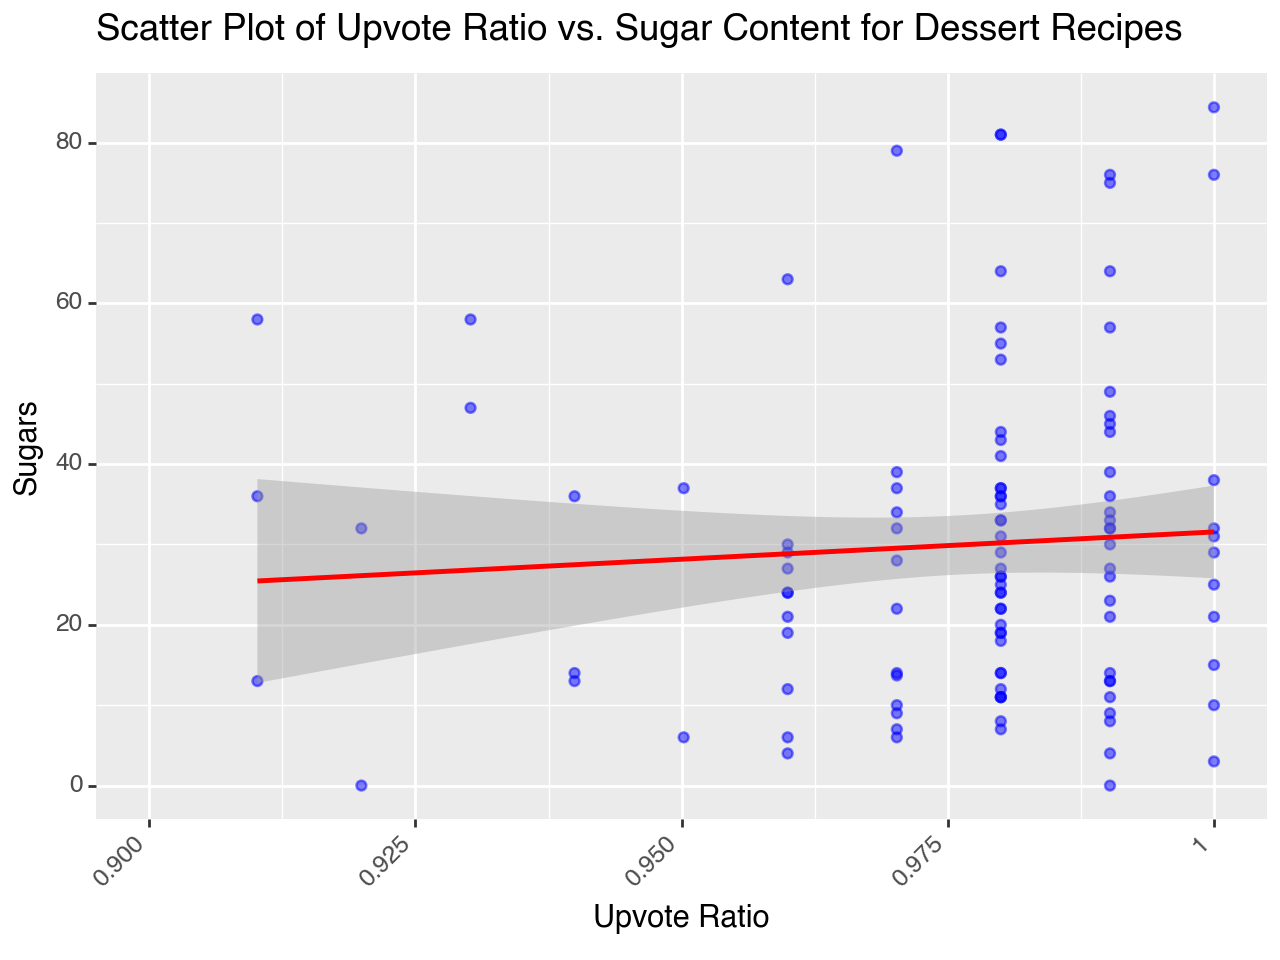

In [ ]:
plot = (
    ggplot(df_desserts, aes(x='upvote_ratio', y='sugars')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Upvote Ratio vs. Sugar Content for Dessert Recipes', x='Upvote Ratio', y='Sugars') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + xlim(0.9, 1)
)

print(plot)

/Users/Yuyao/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


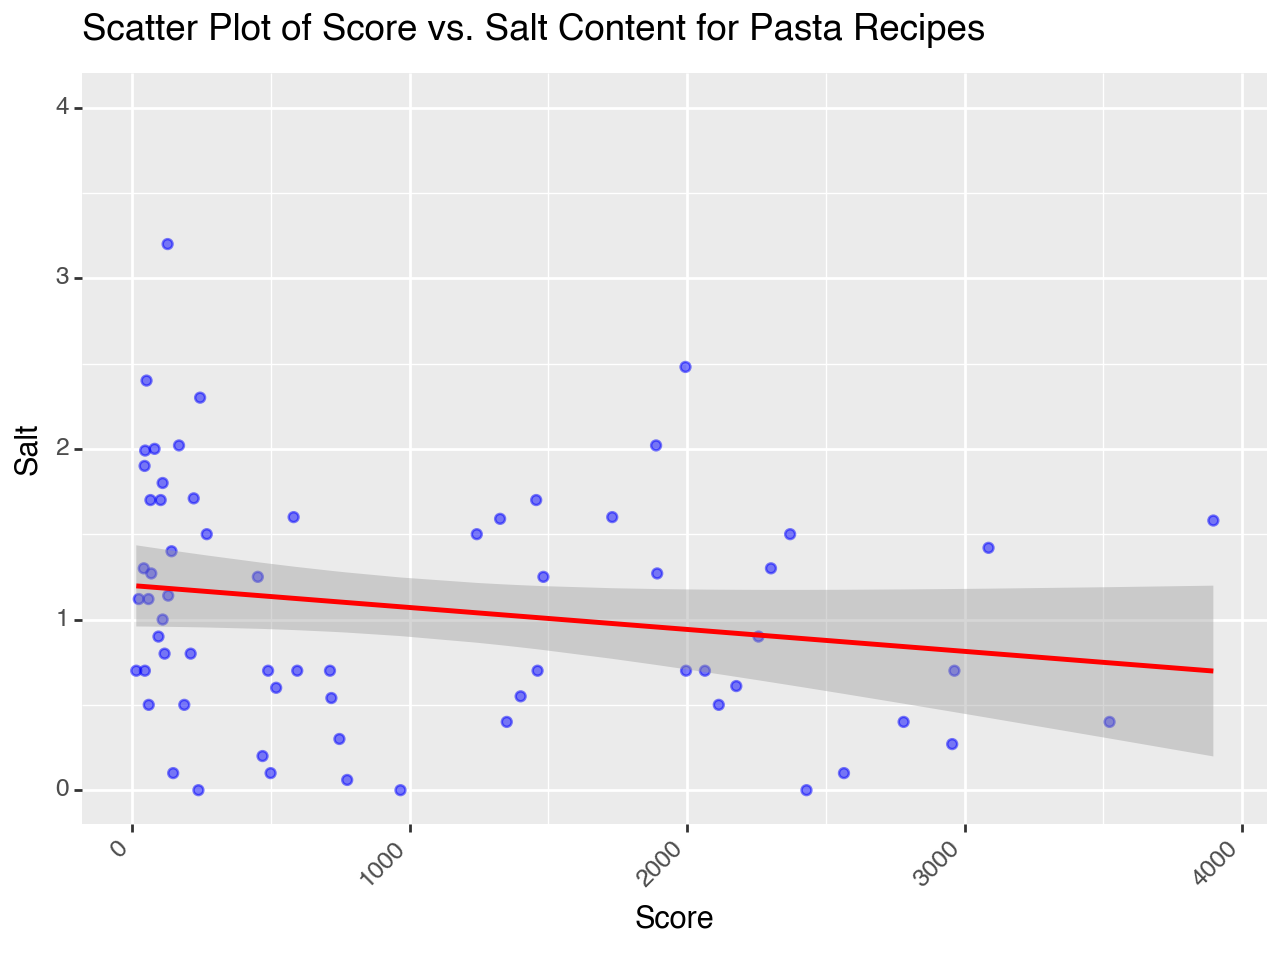

In [118]:
plot = (
    ggplot(df_pasta, aes(x='score', y='salt')) 
    + geom_point(alpha=0.5, color='blue')
    + geom_smooth(method='lm', color='red') 
    + labs(title='Scatter Plot of Score vs. Salt Content for Pasta Recipes', x='Score', y='Salt') 
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + ylim(0, 4)
)

print(plot)